In [21]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
from os.path import join
from evml.keras.models import calc_prob_uncertainty
from bridgescaler import load_scaler, save_scaler
import yaml

In [22]:
def partial_dep_evi(model, data, features, n_points=25):
    
    """ Partial dependence function for classification evidential model. Data input must be a pandas dataframe.
    Supports multiple features being simutaniously perturbed. Total range of calculations is based on the minimum
    and maximums from all combined features. """
    
    pdp_p, pdp_u, pdp_a, pdp_e = [], [], [], []
    data_min = data.loc[:, features].min()
    data_max = data.loc[:, features].max()
    points = np.linspace(data_min, data_max, n_points)
    arr = np.zeros(shape=(data.shape[0], n_points, 4, 4)) 

    for i, j in enumerate(points):
        temp = data.copy()
        temp.loc[:, features] = j # sets all features to perturbed values
        preds = model.predict(scaler.transform(temp), batch_size=10000, verbose=0)
        p, u, a, e = calc_prob_uncertainty(preds)
        
        arr[:, i, :, 0] = np.array(p)
        arr[:, i, :, 1] = np.array(u)
        arr[:, i, :, 2] = np.array(a)
        arr[:, i, :, 3] = np.array(e)
        
    return arr

In [5]:
with open('/glade/work/cbecker/ptype/config/ptype.yml') as config_file:
    config = yaml.safe_load(config_file)
evi_model = tf.keras.models.load_model(join('/glade/scratch/cbecker/ptype_221221', 'model'), compile=False)
scaler = load_scaler('/glade/scratch/cbecker/ptype_221221/scalers/input.json')
scaler.groups_ = scaler.groups_.tolist()
val_in = pd.read_parquet('/glade/scratch/cbecker/ptype_221221/val.parquet')
input_cols = config['TEMP_C'] + config['T_DEWPOINT_C'] + config['UGRD_m/s'] + config['VGRD_m/s']
x_data = val_in[input_cols]
x_transformed = scaler.transform(x_data)

evi_preds = evi_model.predict(x_transformed, batch_size=10000)
evi_probs, evi_u, evi_ale, evi_epi = calc_prob_uncertainty(evi_preds)
class_names = ["ra", "sn", "pl", "fzra"]
evi_class = np.array(evi_probs).argmax(axis=1)

14/14 [==============================] - 6s 391ms/step


In [15]:
# PDP for surface temperature
feature = 'TEMP_C'
features = [f"{feature}_{height}_m" for height in range(0, 250, 250)]
print(features)
pdp_surface = partial_dep_evi(evi_model, x_data, features)

['TEMP_C_0_m']


In [16]:
# Signle PDP for lowest 5 levels of Temperature (all values perturbed)
feature = 'TEMP_C'
features = [f"{feature}_{height}_m" for height in range(0, 1250, 250)]
print(features)
pdp_0_1000m = partial_dep_evi(evi_model, x_data, features)

['TEMP_C_0_m', 'TEMP_C_250_m', 'TEMP_C_500_m', 'TEMP_C_750_m', 'TEMP_C_1000_m']


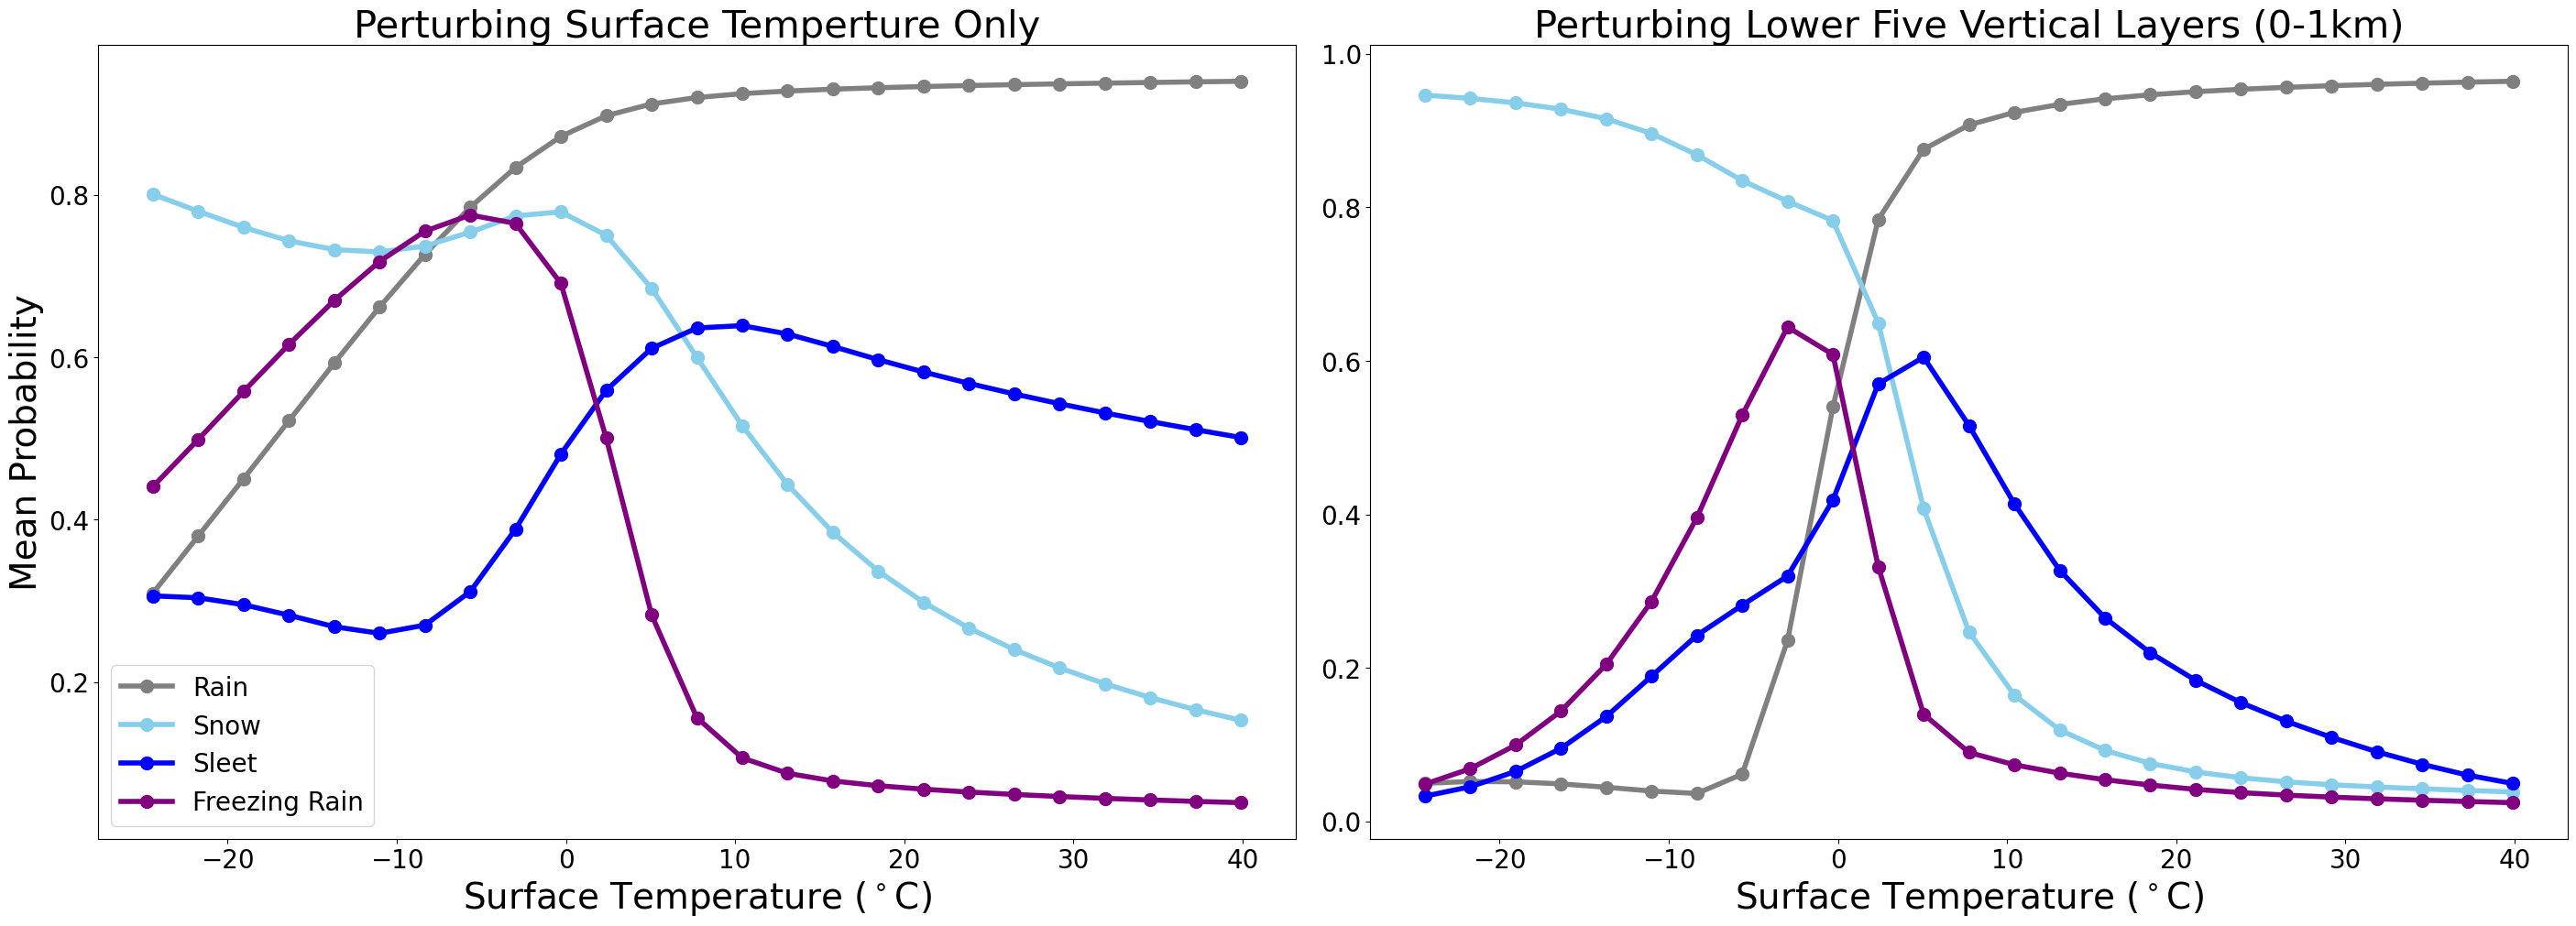

In [18]:
colors = ['grey', 'skyblue', 'blue', 'purple']
labels = ['Rain', 'Snow', 'Sleet', 'Freezing Rain']
fig, ax = plt.subplots(1,2, figsize=(28, 10), sharey=False, constrained_layout=True)
x = np.linspace(x_data.loc[:, features[0]].min(), x_data.loc[:, features[0]].max(), 25)

for i in range(len(colors)): 
    pdp_class_0 = pdp_surface[np.where(evi_class == i)]    # filter by predicted class
    pdp_class_1000 = pdp_0_1000m[np.where(evi_class == i)] # filter by predicted class
    ax[0].plot(x, pdp_class_0.mean(axis=0)[:, i, 0], '-o', markersize=10, color=colors[i], linewidth=4, label=labels[i])
    ax[1].plot(x, pdp_class_1000.mean(axis=0)[:, i, 0], '-o', markersize=10, color=colors[i], linewidth=4, label=labels[i])

ax[0].set_title("Perturbing Surface Temperture Only", fontsize=30)
ax[1].set_title("Perturbing Lower Five Vertical Layers (0-1km)", fontsize=30)
ax[0].set_xlabel('Surface Temperature ($^\circ$C)', fontsize=28)
ax[1].set_xlabel('Surface Temperature ($^\circ$C)', fontsize=28)
ax[0].set_ylabel('Mean Probability', fontsize=28)
ax[0].legend(prop={'size':20})
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

# plt.savefig("/glade/scratch/cbecker/ptype_surface_vs_5lev_2.png", dpi=300, bbox_inches="tight")

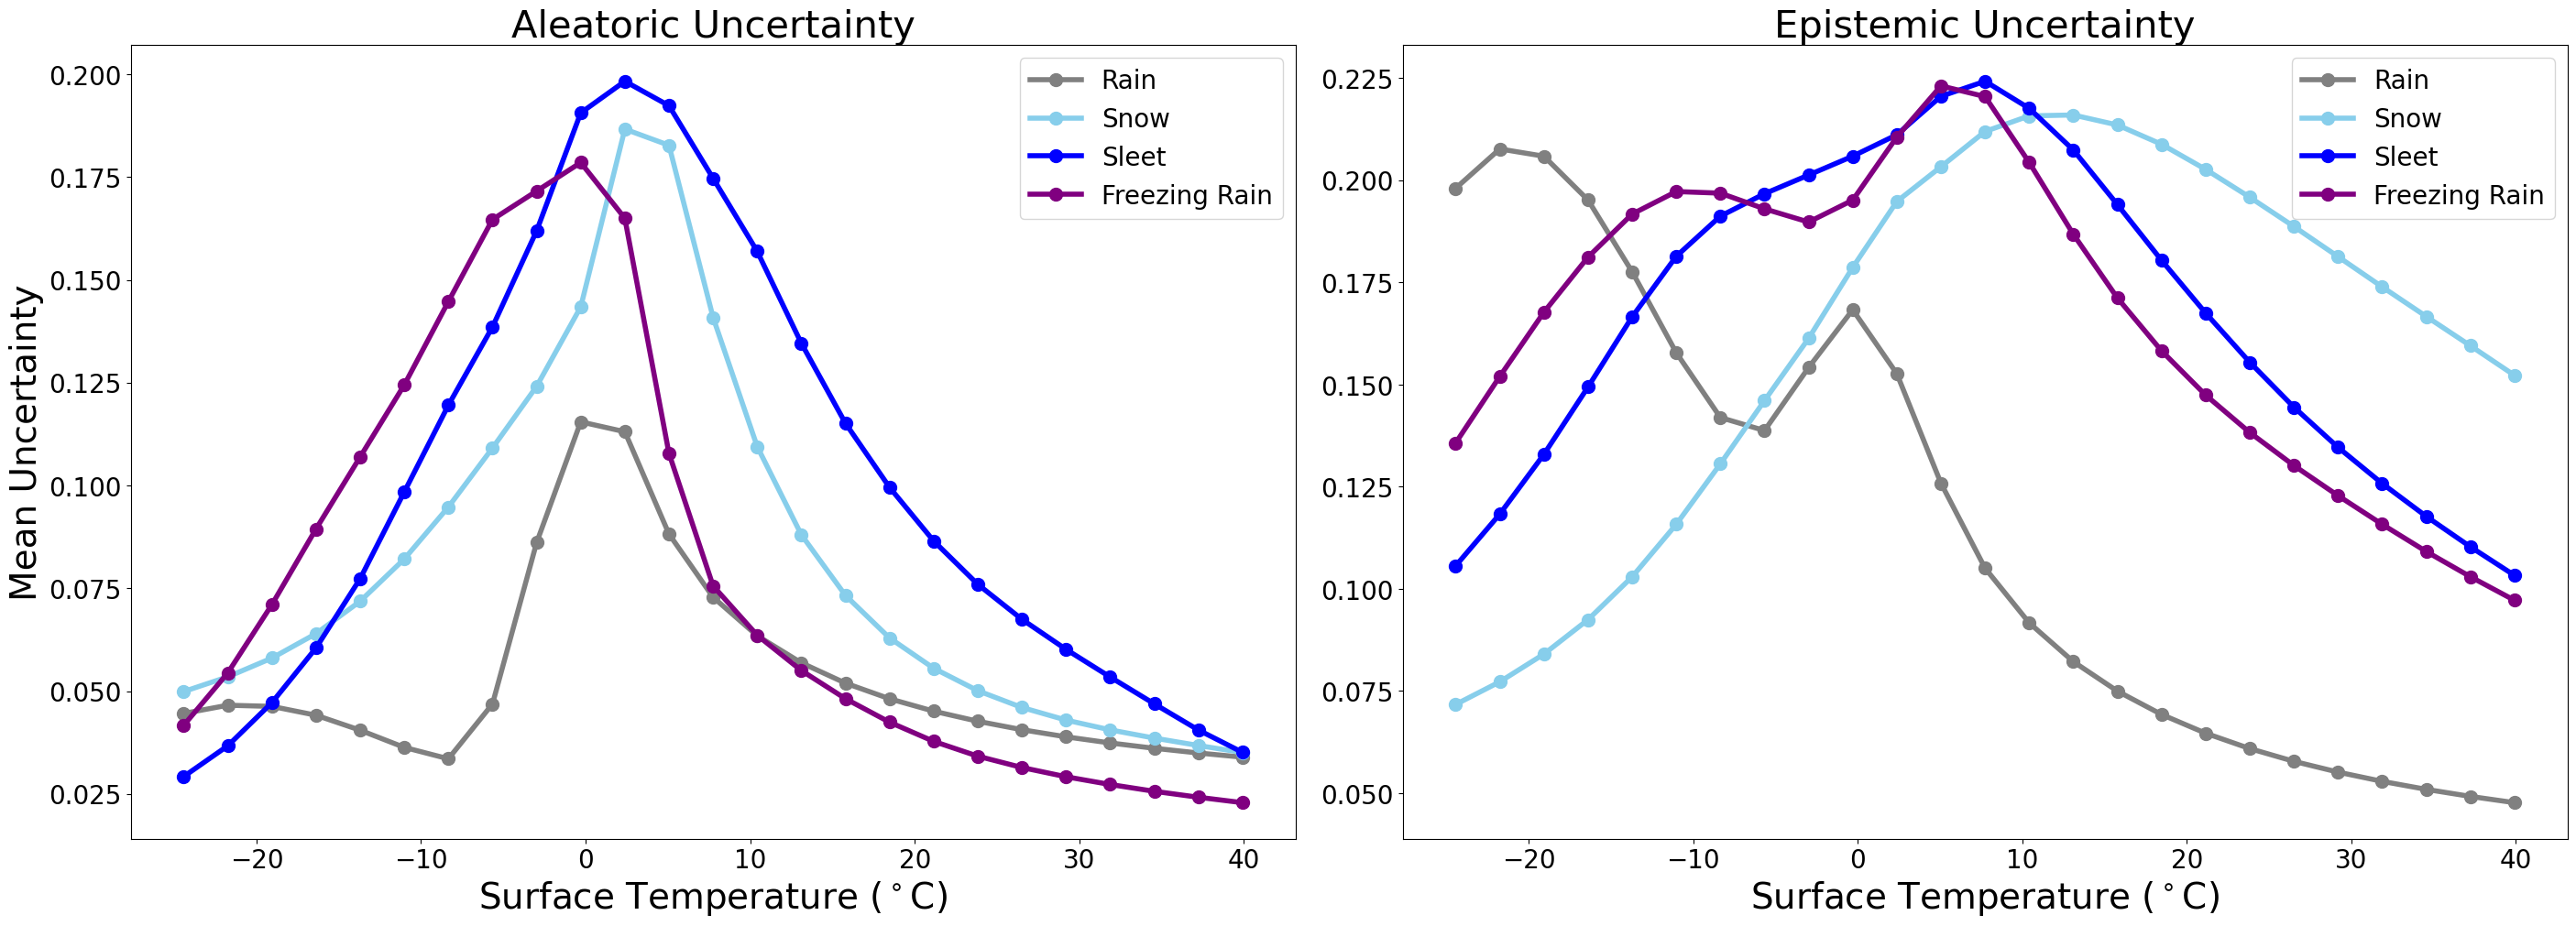

In [19]:
colors = ['grey', 'skyblue', 'blue', 'purple']
labels = ['Rain', 'Snow', 'Sleet', 'Freezing Rain']
fig, ax = plt.subplots(1,2, figsize=(28, 10), sharey=False, constrained_layout=True)
x = np.linspace(x_data.loc[:, features[0]].min(), x_data.loc[:, features[0]].max(), 25)

for i in range(len(colors)): 
    pdp_class_1000 = pdp_0_1000m[np.where(evi_class == i)] # filter by predicted class
    ax[0].plot(x, pdp_class_1000.mean(axis=0)[:, i, 2], '-o', markersize=10, color=colors[i], linewidth=4, label=labels[i])
    ax[1].plot(x, pdp_class_1000.mean(axis=0)[:, i, 1], '-o', markersize=10, color=colors[i], linewidth=4, label=labels[i])

ax[0].set_title("Aleatoric Uncertainty", fontsize=30)
ax[1].set_title("Epistemic Uncertainty", fontsize=30)
ax[0].set_xlabel('Surface Temperature ($^\circ$C)', fontsize=28)
ax[1].set_xlabel('Surface Temperature ($^\circ$C)', fontsize=28)
ax[0].set_ylabel('Mean Uncertainty', fontsize=28)
ax[0].legend(prop={'size':20})
ax[1].legend(prop={'size':20})
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

# plt.savefig("/glade/scratch/cbecker/ptype_ale_epi_1.png", dpi=300, bbox_inches="tight")